In [1]:
from ei_net import * # import the .py file but you can find all the functions at the bottom of this notebook
from utilities import show_values
import matplotlib.pyplot as plt
%matplotlib inline

# Uncertainty and causal emergence in complex networks

# Chapter 01: Effective Information in Networks

## Networks and Causal Structure

Networks provide a powerful syntax for representing a wide range of systems, from the trivially simple to the highly complex. It is common to characterize networks based on structural properties like their degree distribution or whether they show community structure. While our understanding of these structural properties of networks has been crucial for the rapid rise of network science as a discipline, there is a distinct gap in our treatment of both dependencies between nodes and also higher scales in networks. This gap is especially pressing because networks often have an interpretation where links represent dependencies, such as contact networks in epidemiology, neuronal and functional networks in the brain, or interaction networks among cells, genes, or drugs, and these networks can often be analyzed at multiple different scales.

Previously, others have used directed acyclic graphs known as "causal diagrams" to represent causal relationships as dependencies in networks. But there has been little research on quantifying or broadly classifying such causation in networks, particularly those that have both weighted connections and feedback, which are hallmarks of complex systems across domains. Here we introduce information-theoretic measures designed to capture the information contained in the dependencies of networks and which can be used to identify when these networks possess informative higher scales.

## Effective Information

Describing cause and effect implicitly invokes the idea of a network. For example, if a system in a particular state, *A*, always transitions to state *B*, the causal relationship between *A* and *B* can be represented by a node-link diagram wherein the two nodes---*A* and *B*---are connected by a directed arrow, indicating that *B* depends on *A*. In such a network, the out-weight vector, $W^{out}_{i}$, of a node, $v_i$, represents the possible transitions and their probabilities from that node. Specifically, $W^{out}_{i}$ consists of weights $w_{ij}$ between node $v_i$ and its neighbors $v_j$, where $w_{ij}=0.0$ if there is no edge from $v_i$ to $v_j$. This means the edge weights $w_{ij}$ can be interpreted as the probability $p_{ij}$ that a random walker on $v_i$ will transition to $v_j$ in the next time step. We will refer to such a network as having a *causal structure*. 

In the cases where links between nodes represent dependency in general, such as influence, strength, or potential causal interactions, but not explicitly transitions (or where details about transitions is lacking), for our analysis we create $W^{out}_{i}$ by normalizing each node's out-weight vector to sum to $1.0$. This generalizes our results to multiple types of representations (although what sort of dependencies the links in the network represent should be kept in mind when interpreting the values of the measures we introduce below).

A network's causal structure can be characterized by the uncertainty in the relationships among the nodes' out-weights (possible effects) and in-weights (possible causes). The total information in the dependencies between nodes is a function of this uncertainty and can be derived from two fundamental properties. The first is the uncertainty of a node's effects, which can be quantified by the Shannon entropy of its out-weights, $H(W^{out}_{i})$. The average of this entropy, $\langle H(W^{out}_{i} )\rangle $, across all nodes is the amount of noise present in the network's causal structure. Only if $\langle H(W^{out}_{i} )\rangle $ is zero is the network is *deterministic*.

The second fundamental causal property is how weight is distributed across the whole network, $\langle W^{out}_{i}\rangle$. This vector $\langle W^{out}_{i}\rangle$ consists of elements that are the sum of the in-weights $w_{ji}$ to each node $v_i$ from each of its incoming neighbors, $v_j$ (then normalized by total weight of the network). Its entropy, $H (\langle W^{out}_{i}\rangle)$, reflects how certainty is distributed across the network. If all nodes link only to the same node, then $H(\langle W^{out}_{i}\rangle)$ is zero, and the network is totally *degenerate* since all causes lead to the same effect.

From these two properties we can derive the amount of information in a network's causal structure, the *effective information* ($EI$), as:

$$ EI = H(\langle W^{out}_{i} \rangle) - \langle {H}(W^{out}_{i}) \rangle $$ 

Here, we use this measure to develop a general classification of networks. Networks with high $EI$ contain more certainty in the relationships between nodes in the network (since the links represent greater dependencies), whereas networks with low $EI$ contain less certainty.

In this work, we show how the connectivity and different growth rules of a network have a deep relationship to that network's $EI$. This also provides a principled means of quantifying the amount of information among the micro-, meso-, and macroscale dependencies in a network. We introduce a formalism for finding and assessing the most informative scale of a network: the scale that minimizes the uncertainty in the dependencies between nodes. For some networks, a macroscale description of the network can be more informative in this manner, demonstrating a phenomenon known as *causal emergence*.

In [2]:
##########################################
############ PLOTTING SETUP ##############
EI_cmap = "Greys"
where_to_save_pngs = "../figs/pngs/"
where_to_save_pdfs = "../figs/pdfs/"
save = True
##########################################
##########################################

## 1.0 Create a Few Example Transition-Probability Matrices

In [6]:
Copy_Copy = np.array([[1.0, 0.0, 0.0, 0.0],
                      [0.0, 0.0, 1.0, 0.0],
                      [0.0, 1.0, 0.0, 0.0],
                      [0.0, 0.0, 0.0, 1.0]])

And_And   = np.array([[1.0, 0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0, 0.0],
                      [0.0, 0.0, 0.0, 1.0]])

Or_Or     = np.array([[1.0, 0.0, 0.0, 0.0],
                      [0.0, 0.0, 0.0, 1.0],
                      [0.0, 0.0, 0.0, 1.0],
                      [0.0, 0.0, 0.0, 1.0]])

Or_Copy   = np.array([[1.0, 0.0, 0.0, 0.0],
                      [0.0, 0.0, 1.0, 0.0],
                      [0.0, 0.0, 0.0, 1.0],
                      [0.0, 0.0, 0.0, 1.0]])

Star      = np.array([[1.0, 0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0, 0.0]])

### 1.0.1 Plot these TPMs, showing their $EI$ values

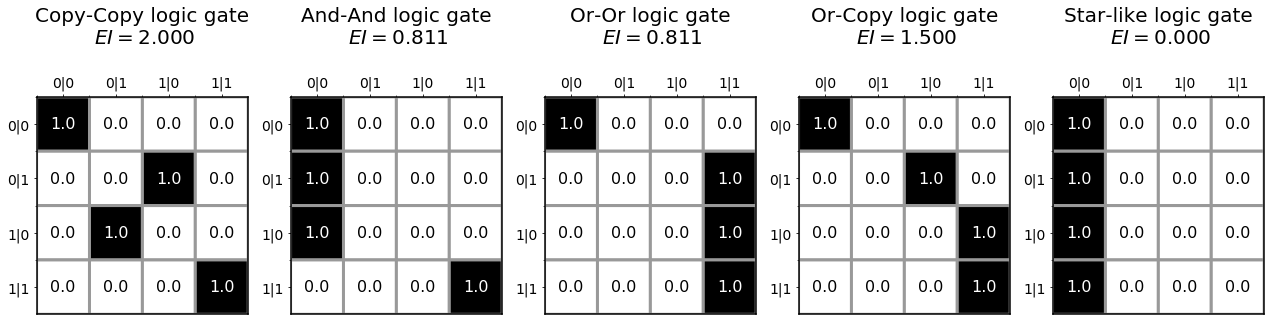

In [7]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(22,4))

c0 = ax0.pcolor(np.arange(-0.5, Copy_Copy.shape[0], 1), np.arange(-0.5, Copy_Copy.shape[0], 1), 
                Copy_Copy, edgecolors='#999999', linewidths=3.0, cmap=EI_cmap)
c1 = ax1.pcolor(np.arange(-0.5, And_And.shape[0], 1), np.arange(-0.5, And_And.shape[0], 1), 
                And_And, edgecolors='#999999', linewidths=3.0, cmap=EI_cmap)
c2 = ax2.pcolor(np.arange(-0.5, Or_Or.shape[0], 1), np.arange(-0.5, Or_Or.shape[0], 1), 
                Or_Or, edgecolors='#999999', linewidths=3.0, cmap=EI_cmap)
c3 = ax3.pcolor(np.arange(-0.5, Or_Copy.shape[0], 1), np.arange(-0.5, Or_Copy.shape[0], 1), 
                Or_Copy, edgecolors='#999999', linewidths=3.0, cmap=EI_cmap)
c4 = ax4.pcolor(np.arange(-0.5, Star.shape[0], 1), np.arange(-0.5, Star.shape[0], 1), 
                Star, edgecolors='#999999', linewidths=3.0, cmap=EI_cmap)

show_values(c0, ax=ax0, fmt="%.1f", fontsize=16)
show_values(c1, ax=ax1, fmt="%.1f", fontsize=16)
show_values(c2, ax=ax2, fmt="%.1f", fontsize=16)
show_values(c3, ax=ax3, fmt="%.1f", fontsize=16)
show_values(c4, ax=ax4, fmt="%.1f", fontsize=16)

ax0.invert_yaxis()
ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
ax4.invert_yaxis()

xlabs = ylabs = ['0|0','0|1', '1|0', '1|1']

ax0.set_xticks(np.arange(0, Copy_Copy.shape[0], 1))
ax0.set_yticks(np.arange(0, Copy_Copy.shape[1], 1))
ax0.set_xticklabels(xlabs, fontsize=14)
ax0.set_yticklabels(ylabs, fontsize=14)
ax0.set_xticks(np.arange(-0.5, Copy_Copy.shape[0]-0.5, 1), minor=True)
ax0.set_yticks(np.arange(-0.5, Copy_Copy.shape[1]-0.5, 1), minor=True)

ax1.set_xticks(np.arange(0, And_And.shape[0], 1))
ax1.set_yticks(np.arange(0, And_And.shape[1], 1))
ax1.set_xticklabels(xlabs, fontsize=14)
ax1.set_yticklabels(ylabs, fontsize=14)
ax1.set_xticks(np.arange(-0.5, And_And.shape[0]-0.5, 1), minor=True)
ax1.set_yticks(np.arange(-0.5, And_And.shape[1]-0.5, 1), minor=True)

ax2.set_xticks(np.arange(0, Or_Or.shape[0], 1))
ax2.set_yticks(np.arange(0, Or_Or.shape[1], 1))
ax2.set_xticklabels(xlabs, fontsize=14)
ax2.set_yticklabels(ylabs, fontsize=14)
ax2.set_xticks(np.arange(-0.5, Or_Or.shape[0]-0.5, 1), minor=True)
ax2.set_yticks(np.arange(-0.5, Or_Or.shape[1]-0.5, 1), minor=True)

ax3.set_xticks(np.arange(0, Or_Copy.shape[0], 1))
ax3.set_yticks(np.arange(0, Or_Copy.shape[1], 1))
ax3.set_xticklabels(xlabs, fontsize=14)
ax3.set_yticklabels(ylabs, fontsize=14)
ax3.set_xticks(np.arange(-0.5, Or_Copy.shape[0]-0.5, 1), minor=True)
ax3.set_yticks(np.arange(-0.5, Or_Copy.shape[1]-0.5, 1), minor=True)

ax4.set_xticks(np.arange(0, Star.shape[0], 1))
ax4.set_yticks(np.arange(0, Star.shape[1], 1))
ax4.set_xticklabels(xlabs, fontsize=14)
ax4.set_yticklabels(ylabs, fontsize=14)
ax4.set_xticks(np.arange(-0.5, Star.shape[0]-0.5, 1), minor=True)
ax4.set_yticks(np.arange(-0.5, Star.shape[1]-0.5, 1), minor=True)

ax0.xaxis.tick_top()
ax1.xaxis.tick_top()
ax2.xaxis.tick_top()
ax3.xaxis.tick_top()
ax4.xaxis.tick_top()

ax0.set_title('Copy-Copy logic gate\n $EI = %.3f$ \n'%EI(Copy_Copy), fontsize=20, pad=10)
ax1.set_title('And-And logic gate\n $EI = %.3f$ \n'%EI(And_And),     fontsize=20, pad=10)
ax2.set_title('Or-Or logic gate\n $EI = %.3f$ \n'%EI(Or_Or),         fontsize=20, pad=10)
ax3.set_title('Or-Copy logic gate\n $EI = %.3f$ \n'%EI(Or_Copy),     fontsize=20, pad=10)
ax4.set_title('Star-like logic gate\n $EI = %.3f$ \n'%EI(Star),      fontsize=20, pad=10)

if save:
    plt.savefig(where_to_save_pngs+"Example1_LogicGates.png", bbox_inches='tight', dpi=425)
    plt.savefig(where_to_save_pdfs+"Example1_LogicGates.pdf", bbox_inches='tight')

plt.show()

______________________

## 1.1 Add noise to the transition probability matrices

In [8]:
Copy_Copy_noise = Copy_Copy + np.random.uniform(0.0,0.1,size=Copy_Copy.shape)
Copy_Copy_noise = Copy_Copy_noise / Copy_Copy_noise.sum(axis=1)

And_And_noise   = And_And   + np.random.uniform(0.0,0.1,size=And_And.shape)
And_And_noise   = And_And_noise / And_And_noise.sum(axis=1)

Or_Or_noise     = Or_Or     + np.random.uniform(0.0,0.1,size=Or_Or.shape)
Or_Or_noise     = Or_Or_noise / Or_Or_noise.sum(axis=1)

Or_Copy_noise   = Or_Copy   + np.random.uniform(0.0,0.1,size=Or_Copy.shape)
Or_Copy_noise   = Or_Copy_noise / Or_Copy_noise.sum(axis=1)

Star_noise      = Star      + np.random.uniform(0.0,0.1,size=Star.shape)
Star_noise      = Star_noise / Star_noise.sum(axis=1)

### 1.1.1 Plot these TPMs, showing their $EI$ values

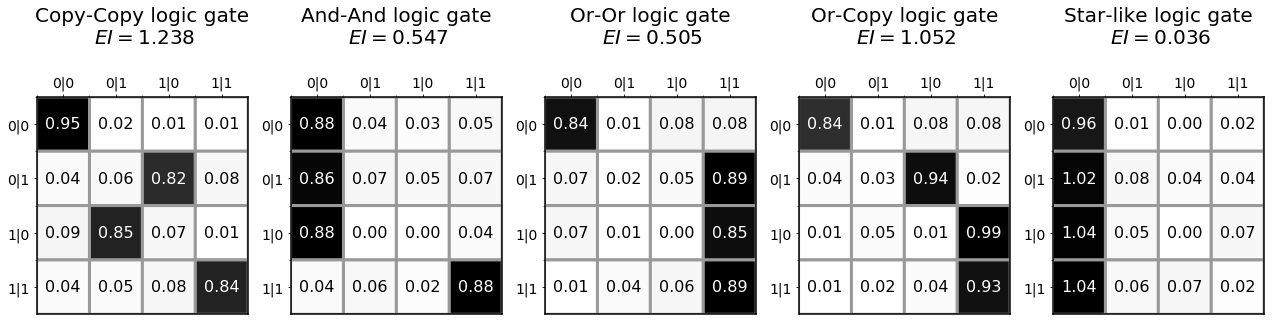

In [9]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(22,4))

c0 = ax0.pcolor(np.arange(-0.5, Copy_Copy_noise.shape[0], 1), np.arange(-0.5, Copy_Copy_noise.shape[0], 1), 
                Copy_Copy_noise, edgecolors='#999999', linewidths=3.0, cmap=EI_cmap)
c1 = ax1.pcolor(np.arange(-0.5, And_And_noise.shape[0], 1), np.arange(-0.5, And_And_noise.shape[0], 1), 
                And_And_noise, edgecolors='#999999', linewidths=3.0, cmap=EI_cmap)
c2 = ax2.pcolor(np.arange(-0.5, Or_Or_noise.shape[0], 1), np.arange(-0.5, Or_Or_noise.shape[0], 1), 
                Or_Or_noise, edgecolors='#999999', linewidths=3.0, cmap=EI_cmap)
c3 = ax3.pcolor(np.arange(-0.5, Or_Copy_noise.shape[0], 1), np.arange(-0.5, Or_Copy_noise.shape[0], 1), 
                Or_Copy_noise, edgecolors='#999999', linewidths=3.0, cmap=EI_cmap)
c4 = ax4.pcolor(np.arange(-0.5, Star_noise.shape[0], 1), np.arange(-0.5, Star_noise.shape[0], 1), 
                Star_noise, edgecolors='#999999', linewidths=3.0, cmap=EI_cmap)

show_values(c0, ax=ax0, fmt="%.2f", fontsize=16)
show_values(c1, ax=ax1, fmt="%.2f", fontsize=16)
show_values(c2, ax=ax2, fmt="%.2f", fontsize=16)
show_values(c3, ax=ax3, fmt="%.2f", fontsize=16)
show_values(c4, ax=ax4, fmt="%.2f", fontsize=16)

ax0.invert_yaxis()
ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
ax4.invert_yaxis()

xlabs = ylabs = ['0|0','0|1', '1|0', '1|1']

ax0.set_xticks(np.arange(0, Copy_Copy_noise.shape[0], 1))
ax0.set_yticks(np.arange(0, Copy_Copy_noise.shape[1], 1))
ax0.set_xticklabels(xlabs, fontsize=14)
ax0.set_yticklabels(ylabs, fontsize=14)
ax0.set_xticks(np.arange(-0.5, Copy_Copy_noise.shape[0]-0.5, 1), minor=True)
ax0.set_yticks(np.arange(-0.5, Copy_Copy_noise.shape[1]-0.5, 1), minor=True)

ax1.set_xticks(np.arange(0, And_And_noise.shape[0], 1))
ax1.set_yticks(np.arange(0, And_And_noise.shape[1], 1))
ax1.set_xticklabels(xlabs, fontsize=14)
ax1.set_yticklabels(ylabs, fontsize=14)
ax1.set_xticks(np.arange(-0.5, And_And_noise.shape[0]-0.5, 1), minor=True)
ax1.set_yticks(np.arange(-0.5, And_And_noise.shape[1]-0.5, 1), minor=True)

ax2.set_xticks(np.arange(0, Or_Or_noise.shape[0], 1))
ax2.set_yticks(np.arange(0, Or_Or_noise.shape[1], 1))
ax2.set_xticklabels(xlabs, fontsize=14)
ax2.set_yticklabels(ylabs, fontsize=14)
ax2.set_xticks(np.arange(-0.5, Or_Or_noise.shape[0]-0.5, 1), minor=True)
ax2.set_yticks(np.arange(-0.5, Or_Or_noise.shape[1]-0.5, 1), minor=True)

ax3.set_xticks(np.arange(0, Or_Copy_noise.shape[0], 1))
ax3.set_yticks(np.arange(0, Or_Copy_noise.shape[1], 1))
ax3.set_xticklabels(xlabs, fontsize=14)
ax3.set_yticklabels(ylabs, fontsize=14)
ax3.set_xticks(np.arange(-0.5, Or_Copy_noise.shape[0]-0.5, 1), minor=True)
ax3.set_yticks(np.arange(-0.5, Or_Copy_noise.shape[1]-0.5, 1), minor=True)

ax4.set_xticks(np.arange(0, Star_noise.shape[0], 1))
ax4.set_yticks(np.arange(0, Star_noise.shape[1], 1))
ax4.set_xticklabels(xlabs, fontsize=14)
ax4.set_yticklabels(ylabs, fontsize=14)
ax4.set_xticks(np.arange(-0.5, Star_noise.shape[0]-0.5, 1), minor=True)
ax4.set_yticks(np.arange(-0.5, Star_noise.shape[1]-0.5, 1), minor=True)

ax0.xaxis.tick_top()
ax1.xaxis.tick_top()
ax2.xaxis.tick_top()
ax3.xaxis.tick_top()
ax4.xaxis.tick_top()

ax0.set_title('Copy-Copy logic gate\n $EI = %.3f$ \n'%EI(Copy_Copy_noise), fontsize=20, pad=10)
ax1.set_title('And-And logic gate\n $EI = %.3f$ \n'%EI(And_And_noise),     fontsize=20, pad=10)
ax2.set_title('Or-Or logic gate\n $EI = %.3f$ \n'%EI(Or_Or_noise),         fontsize=20, pad=10)
ax3.set_title('Or-Copy logic gate\n $EI = %.3f$ \n'%EI(Or_Copy_noise),     fontsize=20, pad=10)
ax4.set_title('Star-like logic gate\n $EI = %.3f$ \n'%EI(Star_noise),      fontsize=20, pad=10)

if save:
    plt.savefig(where_to_save_pngs+"Example2_LogicGates.png", bbox_inches='tight', dpi=425)
    plt.savefig(where_to_save_pdfs+"Example2_LogicGates.pdf", bbox_inches='tight')

plt.show()

_______________________

## 1.2 Random Matrices

In [10]:
rand0 = np.random.rand(4,4)
rand0 = np.array([rand0[i]/sum(rand0[i]) for i in range(rand0.shape[0])])

rand1 = np.random.rand(4,4)
rand1 = np.array([rand1[i]/sum(rand1[i]) for i in range(rand1.shape[0])])

rand2 = np.random.rand(4,4)
rand2 = np.array([rand2[i]/sum(rand2[i]) for i in range(rand2.shape[0])])

rand3 = np.random.rand(4,4)
rand3 = np.array([rand3[i]/sum(rand3[i]) for i in range(rand3.shape[0])])

rand4 = np.random.rand(4,4)
rand4 = np.array([rand4[i]/sum(rand4[i]) for i in range(rand4.shape[0])])

### 1.2.1 Plot these TPMs, showing their $EI$ values

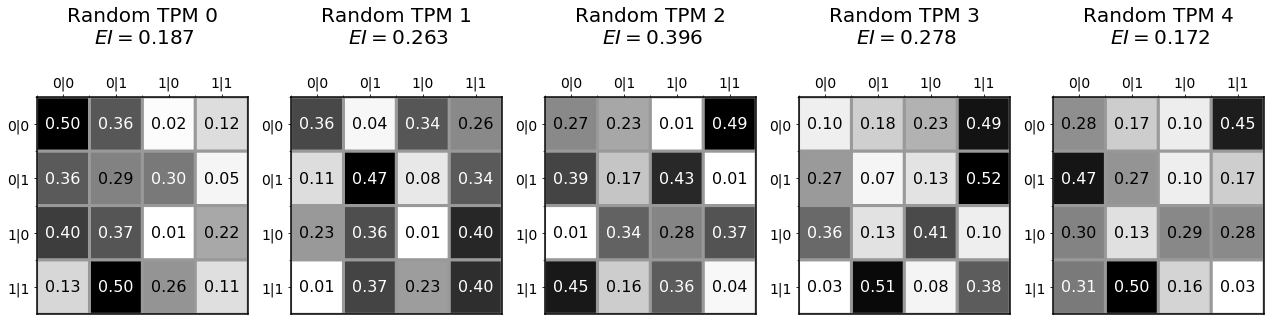

In [11]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(22,4))

c0 = ax0.pcolor(np.arange(-0.5, rand0.shape[0], 1), np.arange(-0.5, rand0.shape[0], 1), 
                rand0, edgecolors='#999999', linewidths=3.0, cmap=EI_cmap)
c1 = ax1.pcolor(np.arange(-0.5, rand1.shape[0], 1), np.arange(-0.5, rand1.shape[0], 1), 
                rand1, edgecolors='#999999', linewidths=3.0, cmap=EI_cmap)
c2 = ax2.pcolor(np.arange(-0.5, rand2.shape[0], 1), np.arange(-0.5, rand2.shape[0], 1), 
                rand2, edgecolors='#999999', linewidths=3.0, cmap=EI_cmap)
c3 = ax3.pcolor(np.arange(-0.5, rand3.shape[0], 1), np.arange(-0.5, rand3.shape[0], 1), 
                rand3, edgecolors='#999999', linewidths=3.0, cmap=EI_cmap)
c4 = ax4.pcolor(np.arange(-0.5, rand4.shape[0], 1), np.arange(-0.5, rand4.shape[0], 1), 
                rand4, edgecolors='#999999', linewidths=3.0, cmap=EI_cmap)

show_values(c0, ax=ax0, fmt="%.2f", fontsize=16)
show_values(c1, ax=ax1, fmt="%.2f", fontsize=16)
show_values(c2, ax=ax2, fmt="%.2f", fontsize=16)
show_values(c3, ax=ax3, fmt="%.2f", fontsize=16)
show_values(c4, ax=ax4, fmt="%.2f", fontsize=16)

ax0.invert_yaxis()
ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
ax4.invert_yaxis()

xlabs = ylabs = ['0|0','0|1', '1|0', '1|1']

ax0.set_xticks(np.arange(0, rand0.shape[0], 1))
ax0.set_yticks(np.arange(0, rand0.shape[1], 1))
ax0.set_xticklabels(xlabs, fontsize=14)
ax0.set_yticklabels(ylabs, fontsize=14)
ax0.set_xticks(np.arange(-0.5, rand0.shape[0]-0.5, 1), minor=True)
ax0.set_yticks(np.arange(-0.5, rand0.shape[1]-0.5, 1), minor=True)

ax1.set_xticks(np.arange(0, rand1.shape[0], 1))
ax1.set_yticks(np.arange(0, rand1.shape[1], 1))
ax1.set_xticklabels(xlabs, fontsize=14)
ax1.set_yticklabels(ylabs, fontsize=14)
ax1.set_xticks(np.arange(-0.5, rand1.shape[0]-0.5, 1), minor=True)
ax1.set_yticks(np.arange(-0.5, rand1.shape[1]-0.5, 1), minor=True)

ax2.set_xticks(np.arange(0, rand2.shape[0], 1))
ax2.set_yticks(np.arange(0, rand2.shape[1], 1))
ax2.set_xticklabels(xlabs, fontsize=14)
ax2.set_yticklabels(ylabs, fontsize=14)
ax2.set_xticks(np.arange(-0.5, rand2.shape[0]-0.5, 1), minor=True)
ax2.set_yticks(np.arange(-0.5, rand2.shape[1]-0.5, 1), minor=True)

ax3.set_xticks(np.arange(0, rand3.shape[0], 1))
ax3.set_yticks(np.arange(0, rand3.shape[1], 1))
ax3.set_xticklabels(xlabs, fontsize=14)
ax3.set_yticklabels(ylabs, fontsize=14)
ax3.set_xticks(np.arange(-0.5, rand3.shape[0]-0.5, 1), minor=True)
ax3.set_yticks(np.arange(-0.5, rand3.shape[1]-0.5, 1), minor=True)

ax4.set_xticks(np.arange(0, rand4.shape[0], 1))
ax4.set_yticks(np.arange(0, rand4.shape[1], 1))
ax4.set_xticklabels(xlabs, fontsize=14)
ax4.set_yticklabels(ylabs, fontsize=14)
ax4.set_xticks(np.arange(-0.5, rand4.shape[0]-0.5, 1), minor=True)
ax4.set_yticks(np.arange(-0.5, rand4.shape[1]-0.5, 1), minor=True)

ax0.xaxis.tick_top()
ax1.xaxis.tick_top()
ax2.xaxis.tick_top()
ax3.xaxis.tick_top()
ax4.xaxis.tick_top()

ax0.set_title('Random TPM 0\n $EI = %.3f$ \n'%EI(rand0), fontsize=20, pad=10)
ax1.set_title('Random TPM 1\n $EI = %.3f$ \n'%EI(rand1), fontsize=20, pad=10)
ax2.set_title('Random TPM 2\n $EI = %.3f$ \n'%EI(rand2), fontsize=20, pad=10)
ax3.set_title('Random TPM 3\n $EI = %.3f$ \n'%EI(rand3), fontsize=20, pad=10)
ax4.set_title('Random TPM 4\n $EI = %.3f$ \n'%EI(rand4), fontsize=20, pad=10)

if save:
    plt.savefig(where_to_save_pngs+"Example3_RandomTPMs.png", bbox_inches='tight', dpi=425)
    plt.savefig(where_to_save_pdfs+"Example3_RandomTPMs.pdf", bbox_inches='tight')

plt.show()

## 1.3 Example calculation figure (Supplemental Information, Figure 1)

In [3]:
##########################################
############ PLOTTING SETUP ##############
from matplotlib import gridspec

plt.rc('axes', linewidth=3)
font = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 28}
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
##########################################
##########################################

In [4]:
TPM = np.array([[0.0, 0.0, 0.0, 0.5, 0.5],
                [1/3, 0.0, 1/3, 1/3, 0.0],
                [0.0, 0.5, 0.0, 0.5, 0.0],
                [0.0, 0.0, 0.0, 0.0, 1.0],
                [0.5, 0.0, 0.0, 0.5, 0.0]])

/Users/brennan/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/brennan/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/brennan/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


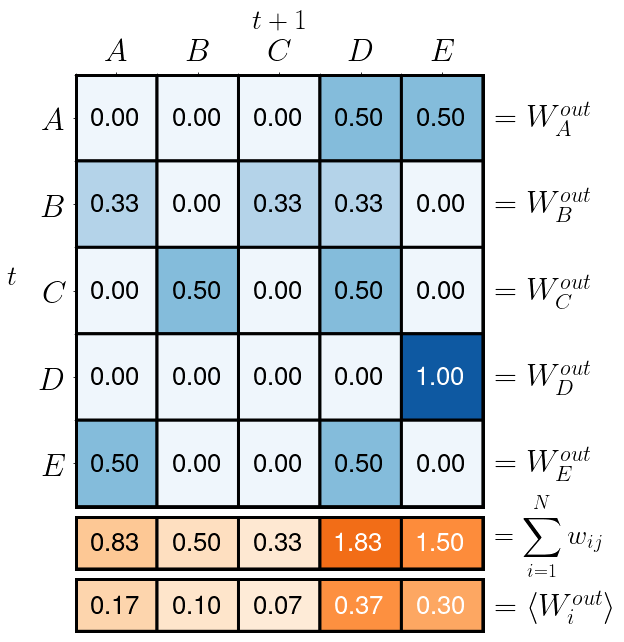

In [5]:
fig = plt.figure(figsize=(7.3, 16))
gs  = gridspec.GridSpec(4, 1, height_ratios=[7, 10, 1.2, 1.2]) 

xlabs = ylabs = ['$A$', '$B$', '$C$', '$D$', '$E$']

ax0 = plt.subplot(gs[1])
ax0.set_xticks(np.arange(0, TPM.shape[0], 1))
ax0.set_yticks(np.arange(0, TPM.shape[0], 1))
ax0.set_xticklabels(xlabs, fontsize=32)
ax0.set_yticklabels(ylabs, fontsize=32)
ax0.set_xticks(np.arange(-0.5, TPM.shape[0]-0.5, 1), minor=True)
ax0.set_yticks(np.arange(-0.5, TPM.shape[0]-0.5, 1), minor=True)
ax0.tick_params(axis='y', which='major', pad=7)

c0 = plt.pcolor(np.arange(-.5, TPM.shape[0], 1), np.arange(-.5, TPM.shape[1], 1), 
                TPM, edgecolors='k', linewidths=3.0, cmap='Blues', vmin=-.05, vmax=1.2)

show_values(c0, ax=ax0, fmt="%.2f", fontsize=26)

ax0.invert_yaxis()
ax0.xaxis.set_label_position("top")
ax0.xaxis.tick_top()
ax0.set_xlabel(r'$t + 1$', size=28, labelpad=8.0)
ax0.set_ylabel(r'$t$', size=28, rotation=0, labelpad=27.0)
ax0.xaxis.label.set_position((0.5,5.0))

ax0.text(4.65, 0.20, '$=W_{A}^{out}$', ha='left', rotation=0, wrap=True, size=32)
ax0.text(4.65, 1.20, '$=W_{B}^{out}$', ha='left', rotation=0, wrap=True, size=32)
ax0.text(4.65, 2.20, '$=W_{C}^{out}$', ha='left', rotation=0, wrap=True, size=32)
ax0.text(4.65, 3.20, '$=W_{D}^{out}$', ha='left', rotation=0, wrap=True, size=32)
ax0.text(4.65, 4.20, '$=W_{E}^{out}$', ha='left', rotation=0, wrap=True, size=32)


ms = 78
ax1 = plt.subplot(gs[2])
Win_j = TPM.sum(axis=0).reshape(1,TPM.shape[0])
Win   = W_IN(TPM).reshape(1,TPM.shape[0])

c1 = plt.pcolor(np.arange(-.5, Win_j.shape[1], 1), np.arange(0.0, 1.5, 1), 
                Win_j, edgecolors='k', linewidths=3.0, cmap='Oranges', vmin=0, vmax=3.0)

show_values(c1, ax=ax1, fmt="%.2f", fontsize=26)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([''])
ax1.set_yticklabels([''])

ax2 = plt.subplot(gs[3])
c2 = plt.pcolor(np.arange(-.5, Win.shape[1], 1), np.arange(0.0, 1.5, 1), 
                Win, edgecolors='k', linewidths=3.0, cmap='Oranges', vmin=0, vmax=0.75)

show_values(c2, ax=ax2, fmt="%.2f", fontsize=26)
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xticklabels([''])
ax2.set_yticklabels([''])

string10 = r'$= \displaystyle\sum_{i=1}^N w_{ij}$'
string20 = r'$= \langle W_{i}^{out} \rangle$'

ax1.text(4.65, -.15, string10, ha='left', rotation=0, wrap=True, size=28)
ax2.text(4.65, 0.15, string20, ha='left', rotation=0, wrap=True, size=32)

plt.subplots_adjust(wspace=0, hspace=0.05)

if save:
    plt.savefig(where_to_save_pngs+"Example4_ExampleTPM.png", bbox_inches='tight', dpi=425)
    plt.savefig(where_to_save_pdfs+"Example4_ExampleTPM.pdf", bbox_inches='tight')

plt.show()

The adjacency matrix of a network with 1.158 bits of effective information. The rows correspond to $W^{out}_{i}$, a vector of probabilities that a random walker on node $v_i$ at time $t$ transitions to $v_j$ in the following time step, $t+1$. $\langle W^{out}_{i}\rangle$ represents the (normalized) input weight distribution of the network, that is, the probabilities that a random walker will arrive at a given node $v_j$ at $t+1$, after a uniform introduction of random walkers into the network at $t$.

In [6]:
Win = W_IN(TPM)
vals = Win
Win_cols   = plt.cm.Oranges(Win+0.15)
WoutA_cols = plt.cm.Blues(max(TPM[0]))
WoutB_cols = plt.cm.Blues(max(TPM[1]))
WoutC_cols = plt.cm.Blues(max(TPM[2]))
WoutD_cols = plt.cm.Blues(max(TPM[3])*0.66)
WoutE_cols = plt.cm.Blues(max(TPM[4]))

/Users/brennan/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


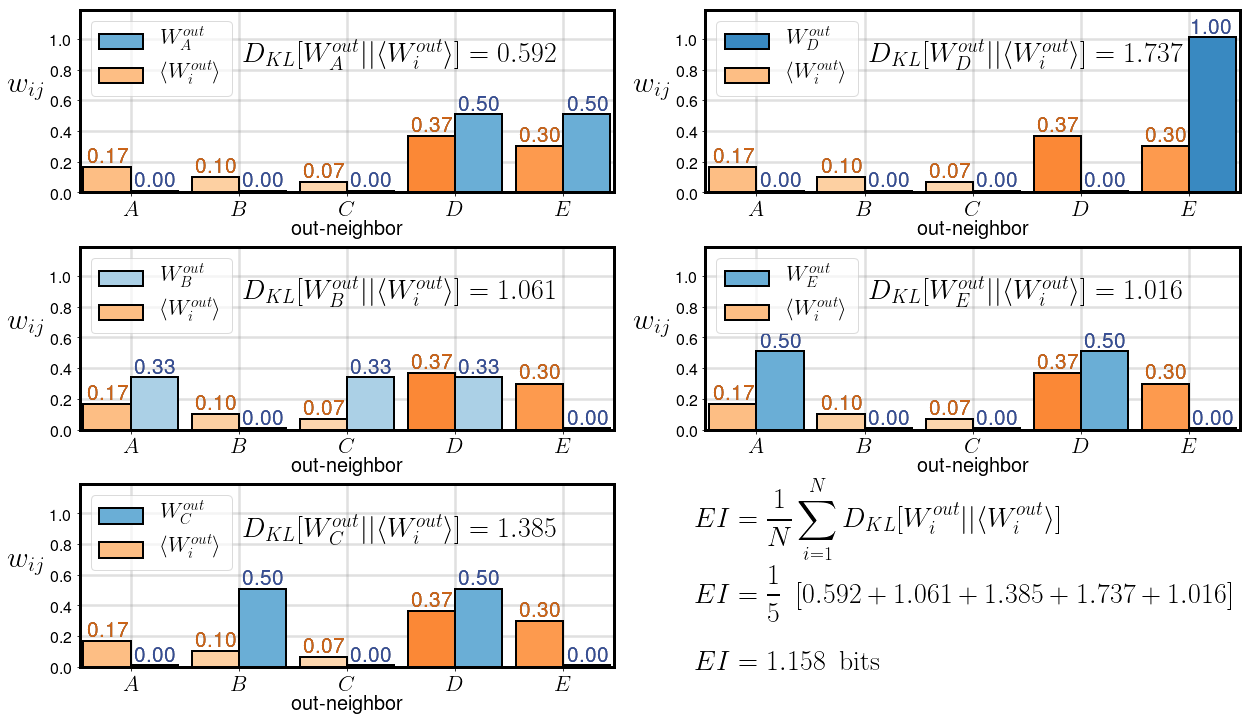

In [7]:
tpm0 = TPM
fig, ((ax00, ax01), (ax02, ax03), (ax04, ax05)) = plt.subplots(3, 2, figsize=(16*1.3,9*1.3))

ax00.bar(np.linspace(0.0, 5.5, 5), TPM[0]+0.01, color=WoutA_cols, linewidth=2.0, edgecolor='k',
         width=0.6, label=r'$W_{A}^{out}$')
x_wij = np.linspace(0.0, 5.5, 5)
y_wij = tpm0[0]
for i in range(len(x_wij)):
    ax00.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center',
              fontsize=21, color='#262626')
    ax00.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center',
              fontsize=21, color='royalblue', alpha=0.6)
    
ax00.bar(np.linspace(-.6, 4.9, 5), vals, color=Win_cols, linewidth=2.0, edgecolor='k',
         width=0.6, label=r'$\langle W_{i}^{out} \rangle$')

x_wij = np.linspace(-.6, 4.9, 5)
y_wij = vals
for i in range(len(x_wij)):
    ax00.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center',
              fontsize=21, color='#262626')
    ax00.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center',
              fontsize=21, color='#e56c13', alpha=0.9)

ax00.set_ylim(0.0,1.19)
ax00.set_xlim(-0.95,5.85)
ax00.set_xticks(np.linspace(-.3, 5.2, 5))
ax00.set_yticks(np.linspace(0, 1, 6))
ax00.set_yticklabels(np.round(np.linspace(0, 1, 6), 2), size=16)
ax00.set_xticklabels(xlabs, size=22)
ax00.set_ylabel(r'$w_{ij}$', fontsize=30, rotation='horizontal', labelpad=25)
ax00.set_xlabel('out-neighbor', fontsize=20, labelpad=0)
ax00.set_axisbelow(True)
ax00.grid(which='major', linestyle='-', color='#999999', linewidth=2.5, alpha=0.3)
ax00.legend(loc=2, fontsize=22, framealpha=0.7)
strax1 = r'$D_{KL}[W^{out}_{A}||\langle W_{i}^{out} \rangle] = %.3f $'%EI_i(tpm0, node_i=0)
ax00.text(3.12, 0.802, strax1, ha='center', fontsize=28, color='k')

ax02.bar(np.linspace(0.0, 5.5, 5), tpm0[1]+0.01, color=WoutB_cols, linewidth=2.0, edgecolor='k',
         width=0.6, label=r'$W_{B}^{out}$')
x_wij = np.linspace(0.0, 5.5, 5)
y_wij = tpm0[1]
for i in range(len(x_wij)):
    ax02.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center', 
              fontsize=21, color='#262626')
    ax02.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center', 
              fontsize=21, color='royalblue', alpha=0.6)

ax02.set_xticklabels(["A", "B", "C", "D", "E"])
ax02.bar(np.linspace(-.6, 4.9, 5), vals, color=Win_cols, linewidth=2.0, edgecolor='k',
         width=0.6, label=r'$\langle W_{i}^{out} \rangle$')
x_wij = np.linspace(-.6, 4.9, 5)
y_wij = vals
for i in range(len(x_wij)):
    ax02.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center', 
              fontsize=21, color='#262626')
    ax02.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center', 
              fontsize=21, color='#e56c13', alpha=0.9)

ax02.set_ylim(0.0,1.19)
ax02.set_xlim(-0.95,5.85)
ax02.set_xticks(np.linspace(-.3, 5.2, 5))
ax02.set_yticks(np.linspace(0, 1, 6))
ax02.set_yticklabels(np.round(np.linspace(0, 1, 6), 2), size=16)
ax02.set_xticklabels(xlabs, size=22)
ax02.set_ylabel(r'$w_{ij}$', fontsize=30, rotation='horizontal', labelpad=25)
ax02.set_xlabel('out-neighbor', fontsize=20, labelpad=0)
ax02.set_axisbelow(True)
ax02.grid(which='major', linestyle='-', color='#999999', linewidth=2.5, alpha=0.3)
ax02.legend(loc=2, fontsize=22, framealpha=0.7)
strax1 = r'$D_{KL}[W^{out}_{B}||\langle W_{i}^{out} \rangle] = %.3f $'%EI_i(tpm0, node_i=1)
ax02.text(3.12, 0.802, strax1, ha='center', fontsize=28, color='k')

ax04.bar(np.linspace(0.0, 5.5, 5), tpm0[2]+0.01, color=WoutC_cols, linewidth=2.0, edgecolor='k',
         width=0.6, label=r'$W_{C}^{out}$')
x_wij = np.linspace(0.0, 5.5, 5)
y_wij = tpm0[2]
for i in range(len(x_wij)):
    ax04.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center', 
              fontsize=21, color='#262626')
    ax04.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center', 
              fontsize=21, color='royalblue', alpha=0.6)

ax04.set_xticklabels(["A", "B", "C", "D", "E"])
ax04.bar(np.linspace(-.6, 4.9, 5), vals, color=Win_cols, linewidth=2.0, edgecolor='k',
         width=0.6, label=r'$\langle W_{i}^{out} \rangle$')

x_wij = np.linspace(-.6, 4.9, 5)
y_wij = vals
for i in range(len(x_wij)):
    ax04.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center',
              fontsize=21, color='#262626')
    ax04.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center', 
              fontsize=21, color='#e56c13', alpha=0.9)

ax04.set_ylim(0.0,1.19)
ax04.set_xlim(-0.95,5.85)
ax04.set_xticks(np.linspace(-.3, 5.2, 5))
ax04.set_yticks(np.linspace(0, 1, 6))
ax04.set_yticklabels(np.round(np.linspace(0, 1, 6), 2), size=16)
ax04.set_xticklabels(xlabs, size=22)
ax04.set_ylabel(r'$w_{ij}$', fontsize=30, rotation='horizontal', labelpad=25)
ax04.set_xlabel('out-neighbor', fontsize=20, labelpad=0)
ax04.set_axisbelow(True)
ax04.grid(which='major', linestyle='-', color='#999999', linewidth=2.5, alpha=0.3)
ax04.legend(loc=2, fontsize=22, framealpha=0.7)
strax1 = r'$D_{KL}[W^{out}_{C}||\langle W_{i}^{out} \rangle] = %.3f $'%EI_i(tpm0, node_i=2)
ax04.text(3.12, 0.802, strax1, ha='center', fontsize=28, color='k')


ax01.bar(np.linspace(0.0, 5.5, 5), tpm0[3]+0.01, color=WoutD_cols, linewidth=2.0, edgecolor='k',
         width=0.6, label=r'$W_{D}^{out}$')
x_wij = np.linspace(0.0, 5.5, 5)
y_wij = tpm0[3]
for i in range(len(x_wij)):
    ax01.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center', 
              fontsize=21, color='#262626')
    ax01.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center', 
              fontsize=21, color='royalblue', alpha=0.6)

ax01.set_xticklabels(["A", "B", "C", "D", "E"])
ax01.bar(np.linspace(-.6, 4.9, 5), vals, color=Win_cols, linewidth=2.0, edgecolor='k',
     width=0.6, label=r'$\langle W_{i}^{out} \rangle$')

x_wij = np.linspace(-.6, 4.9, 5)
y_wij = vals
for i in range(len(x_wij)):
    ax01.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center', 
              fontsize=21, color='#262626')
    ax01.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center', 
              fontsize=21, color='#e56c13', alpha=0.9)

ax01.set_ylim(0.0,1.19)
ax01.set_xlim(-0.95,5.85)
ax01.set_xticks(np.linspace(-.3, 5.2, 5))
ax01.set_yticks(np.linspace(0, 1, 6))
ax01.set_yticklabels(np.round(np.linspace(0, 1, 6), 2), size=16)
ax01.set_xticklabels(xlabs, size=22)
ax01.set_ylabel(r'$w_{ij}$', fontsize=30, rotation='horizontal', labelpad=25)
ax01.set_xlabel('out-neighbor', fontsize=20, labelpad=0)
ax01.set_axisbelow(True)
ax01.grid(which='major', linestyle='-', color='#999999', linewidth=2.5, alpha=0.3)
ax01.legend(loc=2, fontsize=22, framealpha=0.7)
strax1 = r'$D_{KL}[W^{out}_{D}||\langle W_{i}^{out} \rangle] = %.3f $'%EI_i(tpm0, node_i=3)
ax01.text(3.12, 0.802, strax1, ha='center', fontsize=28, color='k')

ax03.bar(np.linspace(0.0, 5.5, 5), tpm0[4]+0.01, color=WoutE_cols, linewidth=2.0, edgecolor='k',
         width=0.6, label=r'$W_{E}^{out}$')
x_wij = np.linspace(0.0, 5.5, 5)
y_wij = tpm0[4]
for i in range(len(x_wij)):
    ax03.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center', 
              fontsize=21, color='#262626')
    ax03.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center', 
              fontsize=21, color='royalblue', alpha=0.6)

ax03.set_xticklabels(["A", "B", "C", "D", "E"])
ax03.bar(np.linspace(-.6, 4.9, 5), vals, color=Win_cols, linewidth=2.0, edgecolor='k',
     width=0.6, label=r'$\langle W_{i}^{out} \rangle$')

x_wij = np.linspace(-.6, 4.9, 5)
y_wij = vals
for i in range(len(x_wij)):
    ax03.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center', 
              fontsize=21, color='#262626')
    ax03.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center', 
              fontsize=21, color='#e56c13', alpha=0.9)

ax03.set_ylim(0.0,1.19)
ax03.set_xlim(-0.95,5.85)
ax03.set_xticks(np.linspace(-.3, 5.2, 5))
ax03.set_yticks(np.linspace(0, 1, 6))
ax03.set_yticklabels(np.round(np.linspace(0, 1, 6), 2), size=16)
ax03.set_xticklabels(xlabs, size=22)
ax03.set_ylabel(r'$w_{ij}$', fontsize=30, rotation='horizontal', labelpad=25)
ax03.set_xlabel('out-neighbor', fontsize=20, labelpad=0)
ax03.set_axisbelow(True)
ax03.grid(which='major', linestyle='-', color='#999999', linewidth=2.5, alpha=0.3)
ax03.legend(loc=2,fontsize=22, framealpha=0.7)
strax1 = r'$D_{KL}[W^{out}_{E}||\langle W_{i}^{out} \rangle] = %.3f $'%EI_i(tpm0, node_i=4)
ax03.text(3.12, 0.802, strax1, ha='center', fontsize=28, color='k')

string1 = r'$EI = \displaystyle\frac{1}{N} \displaystyle\sum_{i=1}^N D_{KL}[W_{i}^{out}|| \
                  \langle W_{i}^{out} \rangle]$'
string2 = r'$EI = \displaystyle\frac{1}{5} \hspace{0.5cm} [0.592 + 1.061 + 1.385 + 1.737 + 1.016]$'
string3 = r'$EI = 1.158 \hspace{0.5cm}$' r'$\rm bits$'
ax05.text(-.02, 0.590, string1, ha='left', rotation=0, wrap=False, size=28)
ax05.text(-.02, 0.250, string2, ha='left', rotation=0, wrap=False, size=28)
ax05.text(-.02, -0.01, string3, ha='left', rotation=0, wrap=False, size=28)

ax05.axis('off')

plt.subplots_adjust(left=None, bottom=0.1, right=None, top=None, wspace=0.17, hspace=0.3)

if save:
    plt.savefig(where_to_save_pngs+"Example4_ExampleCalculation.png", bbox_inches='tight', dpi=425)
    plt.savefig(where_to_save_pdfs+"Example4_ExampleCalculation.pdf", bbox_inches='tight')

plt.show()

Each node's contribution to the $EI$ ($EI_i$) is the KL divergence of its $W^{out}_{i}$ vector from the network's $\langle W^{out}_{i}\rangle$, known as the *effect information*.

$$ EI = \dfrac{1}{N} \displaystyle\sum_{i=1}^N \text{D}_{_{KL}}[W^{out}_{i} || \langle W^{out}_{i} \rangle] $$

where $EI$ is the average of the *effect information*, $EI_i$, of each node. This is equivalent to our derivation of $EI$ from first principles above since

$$
\begin{align}
    EI &= \dfrac{1}{N} \displaystyle\sum_{i=1}^N \text{D}_{_{KL}}[W^{out}_{i} || {\langle W^{out}_{i}\rangle}]\\
    &= \dfrac{1}{N} \displaystyle\sum_{i=1}^{N} \displaystyle\sum_{j=1}^{N} w_{ij}\log_2\bigg(\dfrac{w_{ij}}{W_{j}}\bigg)\\
    &= \dfrac{1}{N}  \displaystyle\sum_{i=1}^{N}\bigg( \displaystyle\sum_{j=1}^{N} w_{ij}\log_2(w_{ij}) - \sum_{j=1}^{N} w_{ij}\log_2(W_{j})\bigg)\\
    &= \dfrac{1}{N}  \displaystyle\sum_{i=1}^{N} \displaystyle\sum_{j=1}^{N} w_{ij}\log_2\big(w_{ij}\big) - \dfrac{1}{N} \displaystyle\sum_{i=1}^{N} \displaystyle\sum_{j=1}^{N} w_{ij}\log_2\big(W_{j}\big)       
\end{align}
$$

- Note that for a given node, $v_i$, the term in the first summation above, $\sum_{j=1}^{N} w_{ij}\log_2\big(w_{ij}\big)$, is equivalent to the negative entropy of the out-weights from $v_i$, $-H(W_i^{out})$. Also note that $W_j$, the *j*th element in the $\langle W^{out}_{i}\rangle$ vector, is the normalized sum of the incoming weights to $v_j$ from its neighbors, $v_i$, such that $W_j=\frac{1}{N} \sum_{i=1}^N w_{ij}$. We substitute these two terms into the equation above such that: 

$$ EI = \dfrac{1}{N}   \sum_{i=1}^{N}-H(W_i^{out}) -  \sum_{j=1}^{N} W_j\log_2\big(W_{j}\big) $$

This is equivalent to the formulation of $EI$ above, since $H(\langle W^{out}_{i}\rangle) = -\sum_{j=1}^{N} W_j\log_2(W_{j})$:

$$ EI = H(\langle W^{out}_{i}\rangle) -\langle H(W_i^{out}) \rangle $$

In this figure, we adopt the relative entropy formulation of $EI$ for ease of derivation.

___________________

## 1.4 Network motifs and effective information (N = 3)

In [3]:
G01 = nx.DiGraph()
G02 = nx.DiGraph()
G03 = nx.DiGraph()
G04 = nx.DiGraph()
G05 = nx.DiGraph()
G06 = nx.DiGraph()
G07 = nx.DiGraph()
G08 = nx.DiGraph()
G09 = nx.DiGraph()
G10 = nx.DiGraph()
G11 = nx.DiGraph()
G12 = nx.DiGraph()
G13 = nx.DiGraph()

G01.add_nodes_from([0,1,2])
G02.add_nodes_from([0,1,2])
G03.add_nodes_from([0,1,2])
G04.add_nodes_from([0,1,2])
G05.add_nodes_from([0,1,2])
G06.add_nodes_from([0,1,2])
G07.add_nodes_from([0,1,2])
G08.add_nodes_from([0,1,2])
G09.add_nodes_from([0,1,2])
G10.add_nodes_from([0,1,2])
G11.add_nodes_from([0,1,2])
G12.add_nodes_from([0,1,2])
G13.add_nodes_from([0,1,2])

G01.add_edges_from([(0,1),(0,2)])
G02.add_edges_from([(0,1),(2,0)])
G03.add_edges_from([(0,1),(0,2),(2,0)])
G04.add_edges_from([(1,0),(2,0)])
G05.add_edges_from([(1,0),(1,2),(0,2)]) # e. coli 
G06.add_edges_from([(1,0),(1,2),(0,2),(0,1)])
G07.add_edges_from([(1,0),(0,2),(2,0)])
G08.add_edges_from([(1,0),(0,1),(0,2),(2,0)])
G09.add_edges_from([(1,0),(0,2),(2,1)])
G10.add_edges_from([(1,0),(2,0),(1,2),(0,1)])
G11.add_edges_from([(1,0),(2,0),(2,1),(0,1)])
G12.add_edges_from([(0,1),(1,0),(1,2),(2,1),(0,2)])
G13.add_edges_from([(0,1),(1,0),(1,2),(2,1),(0,2),(2,0)])

motif_dict = {"Motif 01": {"G":G01, "edges":str(list(G01.edges())), "EI":EI(G01)},
              "Motif 02": {"G":G02, "edges":str(list(G02.edges())), "EI":EI(G02)},
              "Motif 03": {"G":G03, "edges":str(list(G03.edges())), "EI":EI(G03)},
              "Motif 04": {"G":G04, "edges":str(list(G04.edges())), "EI":EI(G04)},
              "Motif 05": {"G":G05, "edges":str(list(G05.edges())), "EI":EI(G05)},
              "Motif 06": {"G":G06, "edges":str(list(G06.edges())), "EI":EI(G06)},
              "Motif 07": {"G":G07, "edges":str(list(G07.edges())), "EI":EI(G07)},
              "Motif 08": {"G":G08, "edges":str(list(G08.edges())), "EI":EI(G08)},
              "Motif 09": {"G":G09, "edges":str(list(G09.edges())), "EI":EI(G09)},
              "Motif 10": {"G":G10, "edges":str(list(G10.edges())), "EI":EI(G10)},
              "Motif 11": {"G":G11, "edges":str(list(G11.edges())), "EI":EI(G11)},
              "Motif 12": {"G":G12, "edges":str(list(G12.edges())), "EI":EI(G12)},
              "Motif 13": {"G":G13, "edges":str(list(G13.edges())), "EI":EI(G13)}}

ei_heights = np.array([list(motif_dict.values())[i]['EI'] 
                       for i in range(len(list(motif_dict.values())))]) + 0.005
ei_bars = np.array(range(len(list(motif_dict.values()))))
colors = ["#486164","#9094c9","#ab4e53","#fa8d11","#74d76c",
          "#bc7dc6","#db453b","#cad24b","#8f52d2","#00aaff",
          "#c2843a","#4f5435","#d05185"]

bar_labels = list(motif_dict.keys())

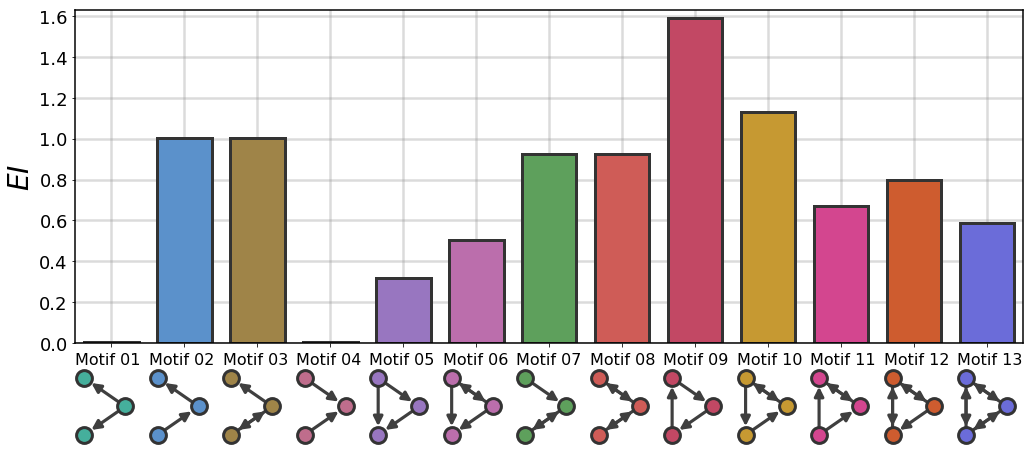

In [4]:
import numpy as np
import networkx as nx
from matplotlib import gridspec

colors = ["#45af9c","#5b91cb","#9f8448","#bf6d8c","#9876c0","#bb6eac","#5ea05c",
          "#cf5c57","#c24864","#c69932","#d3468f","#ce5c2f","#6b6cd9","#78b43d","#ba58c2"]

i = 10 
ns = 250
ew = 3.5
nc = 'w'
ec = '#333333'
oc = '#e4c600'
nc_o = '#333333'


fig, ax = plt.subplots(1,1,figsize=(17,8))
plt.subplots_adjust(wspace=0.10, hspace=0.1)
plt.rc('axes', axisbelow=True)
plt.rc('axes', linewidth=1.5)

gs = gridspec.GridSpec(2, len(ei_bars), height_ratios=[7,1.7])
ax0 = plt.subplot(gs[0, :])
cols_i = 'grey'
ax0.bar(ei_bars, ei_heights, color=colors, width=0.75, 
        edgecolor='#333333', linewidth=3, alpha=1)
ax0.set_xlim(min(ei_bars)-0.5,max(ei_bars)+0.5)
ax0.set_xticks(ei_bars)
ax0.set_xticklabels([""]*13)

ax0.set_yticklabels(np.round(np.linspace(0,1.6,num=9),2), size=18)
ax0.set_ylim(0, max(ei_heights)+0.04)
ax0.set_xlim(-0.5,12.5)
ax0.set_ylabel("$EI$", size=28)
ax0.grid(linestyle='-', color='#999999', linewidth=2.5, alpha=0.35)

for q, Q in enumerate(list(motif_dict.values())):
    g = Q['G']
    ax0 = plt.subplot(gs[-1, q])
    pos = nx.circular_layout(g)
    nx.draw_networkx_nodes(g, pos, node_size=ns, node_color=colors[q], 
                           linewidths=3, edgecolors="#333333", ax=ax0)
    nx.draw_networkx_edges(g, pos, width=ew*0.9, edge_color="#3F3F3F",#colors[q], 
                           arrowsize=19, alpha=1, ax=ax0)
    ax0.set_axis_off()
    posy = np.array(list(zip(*list(pos.values())))[1])
    posx = np.array(list(zip(*list(pos.values())))[0])
    ax0.set_ylim(min(posy)*1.35, max(posy)*1.5)
    ax0.set_xlim(min(posx)*1.69, max(posx)*1.6)
    title = list(motif_dict.keys())[q]
    ax0.set_title(title, fontsize=16, pad=-0.35)

if save:
    plt.savefig("../figs/pngs/EffectiveInformation_NetworkMotifs.png", bbox_inches='tight', dpi=425)
    plt.savefig("../figs/pdfs/EffectiveInformation_NetworkMotifs.pdf", bbox_inches='tight', dpi=425)

plt.show()

## End of Chapter 01. In Chapter 02, we will look at the $EI$ of common networks
_______________

### References:
- __[Hoel, E. P. (2017). When the Map Is Better Than the Territory. Entropy, 19(5), 188. doi: 10.3390/e19050188](http://www.mdpi.com/1099-4300/19/5/188)__
- __[Hoel, E. P., Albantakis, L., & Tononi, G. (2013). Quantifying causal emergence shows that macro can beat micro. Proceedings of the National Academy of Sciences, 110(49), 19790–5. doi: 10.1073/pnas.1314922110](http://www.pnas.org/content/110/49/19790)__
- __[Tononi, G. (2001). Information measures for conscious experience. Archives Italiennes de Biologie,139(4), 367–371.  doi: 10.4449/aib.v139i4.51](https://www.ncbi.nlm.nih.gov/pubmed/11603079)__

______________________